
<a id="1"></a> <br>
## 2. Loading the data

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics
pd.set_option('display.max_columns', 500)

In [ ]:
import feather
#test =feather.read_dataframe('tmp/microsoftv3_4_test')

#train =feather.read_dataframe('tmp/microsoft_train_prep_v1_2m')
#train =feather.read_dataframe('tmp/microsoft_train_prep_v2_2m')
                              #tmp/microsoft_train_prep_v1_full')
train =feather.read_dataframe('tmp/microsoft_train_prep_v2_fullb')
    #'tmp/trainwithdata')

In [ ]:
 no
train=train[train['Date']> '2018-08-28 00:00:00']
del train['Date']
del train['MachineIdentifier']

In [21]:
train.shape

(8921482, 90)

In [22]:
train['third']=train['third'].astype('category')
train['fourth']=train['fourth'].astype('category')


In [ ]:
remove_variables=['Census_ActivationChannel',
 'Census_FlightRing',
 'Census_OSEdition',
 'Census_PowerPlatformRoleName',
 'Census_GenuineStateName',
 'Census_OSSkuName',
 'Census_OSBranch',
 'Census_OSVersion',
 'Census_InternalBatteryType',
 'ProductName',
 'Census_ChassisTypeName',
 'Census_OSArchitecture',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName']
remove_variables=['Census_ActivationChannel',
 'Census_FlightRing',
                  'CityIdentifier',
 'Census_OSEdition',
 'Census_PowerPlatformRoleName',
 'Census_GenuineStateName',
 'Census_OSSkuName',
 'Census_OSBranch',
 'Census_OSVersion',
 'Census_InternalBatteryType',
 'ProductName',
 'Census_ChassisTypeName',
 'Census_OSArchitecture',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName']


In [24]:
print(len(train.columns))
train=train.drop(remove_variables, axis=1)
print(len(train.columns))

90
76


In [25]:
print(train.shape)
train=train.sample(frac=0.2, replace=False)
print(train.shape)

(8921482, 76)
(1784296, 76)


In [26]:
target = train['HasDetections']
del train['HasDetections']

<a id="3"></a> <br>
## 3. Training the model

We set the max number of iteration over folds:

In [27]:
max_iter = 1
param = {'objective':'binary',
          "boosting": "gbdt",
          'learning_rate': 0.05, #################################
          'max_depth': -1, 
          "feature_fraction": 0.8,
          "bagging_freq": 1,
          "bagging_fraction": 0.8 ,
          "bagging_seed": 11,
          "metric": 'auc',
           "lambda_l1": 0.1,
          'num_leaves': 60,
          'min_data_in_leaf': 60,
          "verbosity": -1,
          "random_state": 3}
train.shape

(1784296, 75)

In [28]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
features = train.columns
#predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()
start_time= time.time()
score = [0 for _ in range(folds.n_splits)]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx]
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx]
                          )
# categorical_feature = categorical_features
    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 100)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
   # predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / min(folds.n_splits, max_iter)

    print("time elapsed: {:<5.2}s".format((time.time() - start_time) / 3600))
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])
    if fold_ == max_iter - 1: break
        
#if (folds.n_splits == max_iter):
#    print("CV score: {:<8.5f}".format(metrics.roc_auc_score(target, oof)))
#else:
#     print("CV score: {:<8.5f}".format(sum(score) / max_iter))

fold n°0


/Users/Enzo.Calogero/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.713323	valid_1's auc: 0.712684
[200]	training's auc: 0.723387	valid_1's auc: 0.720948
[300]	training's auc: 0.728419	valid_1's auc: 0.723846
[400]	training's auc: 0.732146	valid_1's auc: 0.725339
[500]	training's auc: 0.735266	valid_1's auc: 0.726232
[600]	training's auc: 0.73817	valid_1's auc: 0.726981
[700]	training's auc: 0.740783	valid_1's auc: 0.72748
[800]	training's auc: 0.743338	valid_1's auc: 0.727978
[900]	training's auc: 0.745818	valid_1's auc: 0.728393
[1000]	training's auc: 0.748214	valid_1's auc: 0.728702
[1100]	training's auc: 0.750488	valid_1's auc: 0.728923
[1200]	training's auc: 0.752685	valid_1's auc: 0.729122
[1300]	training's auc: 0.754881	valid_1's auc: 0.72937
[1400]	training's auc: 0.757037	valid_1's auc: 0.729522
[1500]	training's auc: 0.759176	valid_1's auc: 0.72968
[1600]	training's auc: 0.761189	valid_1's auc: 0.729855
[1700]	training's auc: 0.763228	valid_1's auc: 0.73001

<a id="4"></a> <br>
## 4. Feature importance

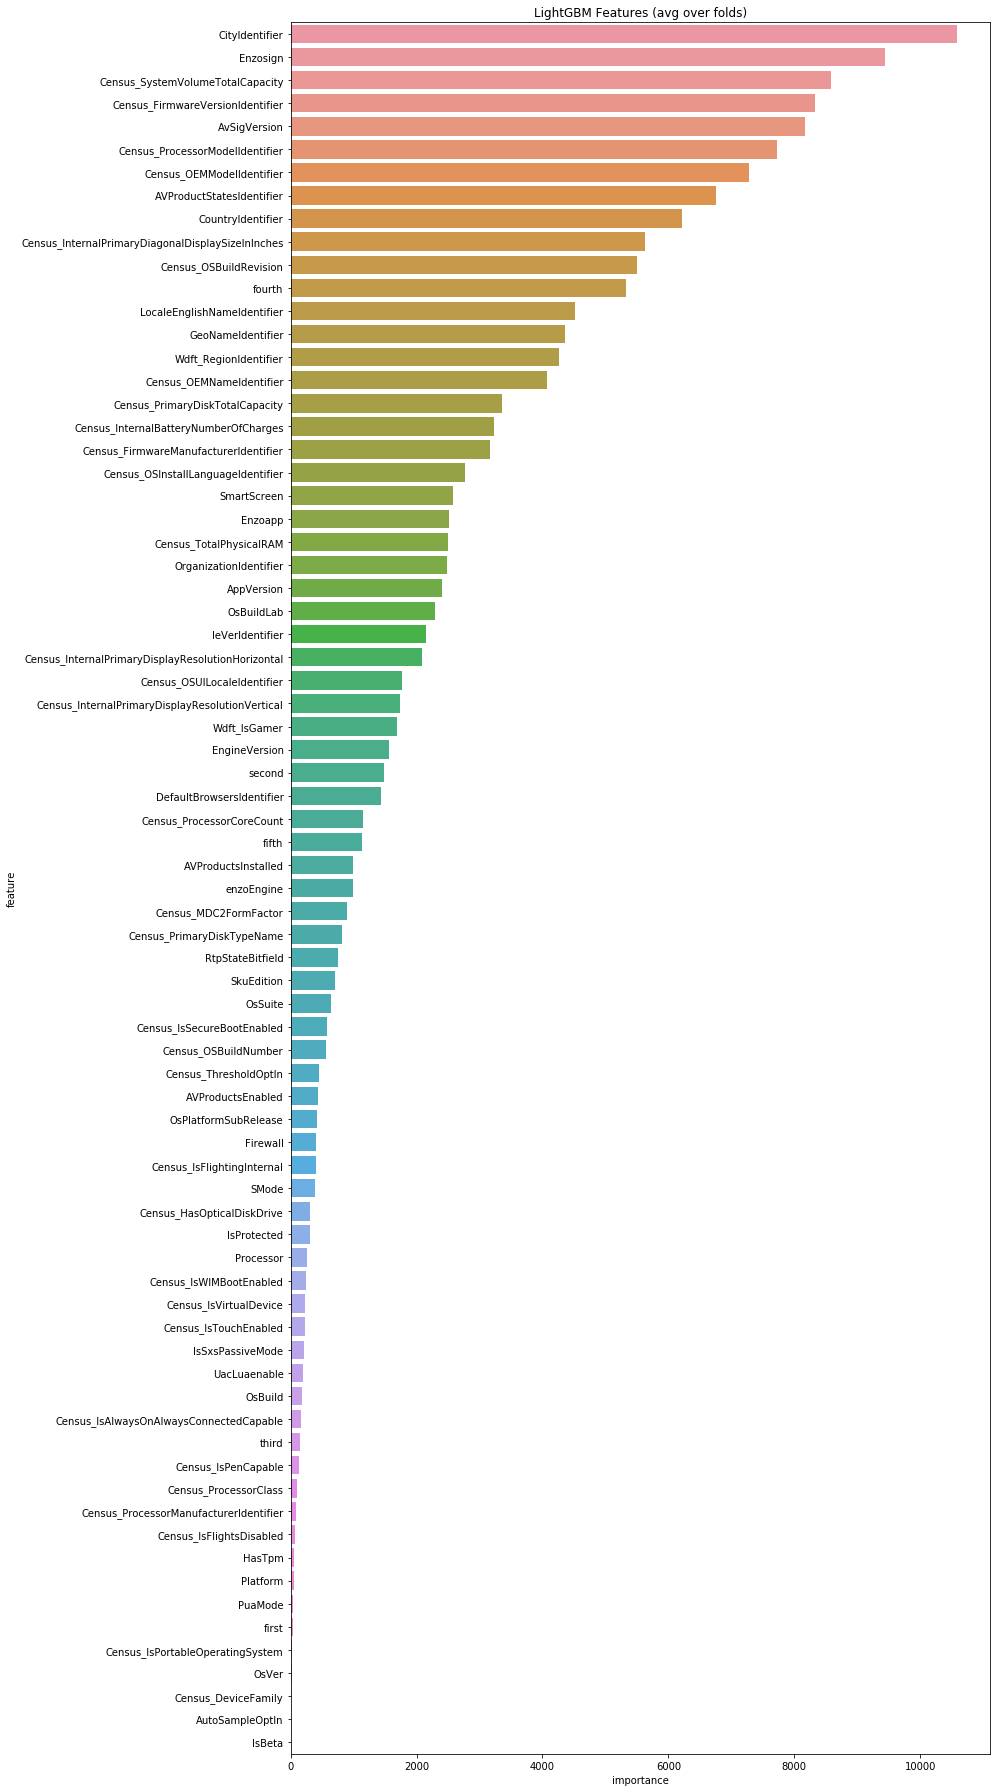

In [29]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importancesv3b_without.png')

In [ ]:
## Predictions

top=sum(best_features.importance)
top

In [ ]:

best_features['imp']=100*best_features.importance/top

In [ ]:
best_features[best_features['feature'].isin(remove_variables)]

In [ ]:
best=best_features[best_features.imp >.2].sort_values('importance')
print(sum(best.imp))
print(len(best.imp))
best

In [ ]:
remove_variable2=list(best.feature)
remove_variable2

In [ ]:
best_features[best_features.fold==1].describe()

In [ ]:
best_features=best_features[best_features.fold==1]
toKeep=best_features[best_features.importance >44]
toKeep.hist()
toKeep.describe()
finale_variables=list(toKeep.feature)

In [ ]:
finale_variables